# Setting Up Your Lab Environment

This guide shows you how to setup a Hashi environment for testing features in Consul, Vault, and Nomad. NOTE: Nomad portion not available, yet.

Things to note about HashiCorp binary types from [releases](https://releases.hashicorp.com/) page.:
* Enterprise binaries (`+ent`) need to be licensed - set in `docker-compose*.yml`
* Consul 1.9, Nomad 1.0, Vault 1.7 has a starter license of 6 hours.
* Consul 1.10+, Nomad 1.1+, and Vault 1.8+ require a license file or they won't start
    * See [HashiCorp Enterprise License](https://learn.hashicorp.com/tutorials/nomad/hashicorp-enterprise-license) Learn guide.
* `Prem` images have their licenses baked in, but are being phased out.

## Prerequisites

### Set Key Variables for your environment

* Customize `CONSUL_DC`, `CONSUL_DC_2`, and `CONSUL_DC_3` if desired.
* Place Consul license files in specified locations if you have them.

> **NOTE**: If using enterprise images make sure license variables are set.

In [ ]:
export CONSUL_DC=zone1 CONSUL_DC_2=zone2 CONSUL_DC_3=zone3

export CONSUL_LICENSE=$(cat consul/cert/consul.hclic)
export VAULT_LICENSE=$(cat vault/config/vault.hclic)

export COMPOSE_PROJECT_NAME=hashi
#// compose file - files on the right take precedence
#export COMPOSE_FILE=docker-compose.yml:docker-compose-proxy.yml:docker-compose-vault.yml:docker-compose-hashi.yml
export COMPOSE_FILE=docker-compose-proxy.yml:docker-compose-hashi.yml:docker-compose-hashicups.yml

In [ ]:
printf "${CONSUL_DC} \n${CONSUL_DC_2} \n${CONSUL_DC_3} \n${COMPOSE_PROJECT_NAME} \n${COMPOSE_FILE}"

* `CONSUL_DC*` - is used for Consul config files, docker-compose files, and more.
* `COMPOSE_FILE` - specifies the docker-compose files to work with

### Install software

#### Install Prerequisite Software

For linux

Install Ansible

> **NOTE**: I run Jupyter notebook in a `python` virtual environment. When I install `ansible` via `pip` in my Jupyter notebook, `ansible` will also be installed only for the virtual environment.

In [ ]:
sudo apt-get install -qq unzip tree python3-pip

In [ ]:
pip install ansible

In [ ]:
ansible --version

#### Install Hashi software

Customize the versions "`*_VER`", architecture "`ARCH`", and os "`OS`" for your environment. It's currently set for Ubuntu on Intel/AMD systems.

In [ ]:
export VAULT_VER=1.8.5+ent #//1.7.8+ent, +ent for enterprise
export CONSUL_VER=1.10.4+ent #1.9.1+ent
export NOMAD_VER=1.0.15+ent #1.2.2+ent, 1.0.15+ent
export ARCH=amd64 #// amd64, arm64
export OS=linux #// darwin, linux

Install via script. Script downloads files, extracts it to `/usr/local/bin`, and enables autocomplete.

In [ ]:
cat scripts/install.sh

In [ ]:
scripts/install.sh

Install for Ubuntu Linux via Repo - UNDER DEVELOPMENT - NOT WORKING FOR ARM64

In [ ]:
ARCH=arm64
# curl -fsSL https://apt.releases.hashicorp.com/gpg | sudo apt-key add -
sudo apt-add-repository \
    "deb [arch=${ARCH}] https://apt.releases.hashicorp.com $(lsb_release -cs) main" \
    && sudo apt-get update #&& sudo apt-get install nomad

#### Install Docker and Docker Compose

* Ubuntu and Raspbian
  * https://dev.to/elalemanyo/how-to-install-docker-and-docker-compose-on-raspberry-pi-1mo
* Mac - https://docs.docker.com/desktop/mac/install/

The script below installs `docker` and `docker-compose` for Linux.

optional - Review script.

In [ ]:
cat scripts/docker.sh

Run script to install `docker` and `docker-compose` for Linux. Adds current user to `docker` group.

In [ ]:
scripts/docker.sh

### option - Install Prereqs Hashi and Docker software via Ansible

This option allows you to install the software packages via `ansible`.

Here's what it will do:
1. Install prerequisites.
1. Install Hashi key, repo, and binaries (Consul, Nomad, and Vault)
1. Enable command autocompletion for Consul, Nomad, and Vault.

Overview of the steps:
1. Download ansible repo.
1. Define playbook.
1. Define variable files.
1. Test run ansible playbook.
1. Run ansible playbook.

In [ ]:
HASHI_ANSIBLE=hashistack-ansible
git clone https://github.com/phanclan/hashistack-ansible ../../hashistack-ansible

Review `playground` playbook if it exists.

In [ ]:
[[ -f ../../hashistack-ansible/ansible/play_playground.yml ]] && \
cat ../../hashistack-ansible/ansible/play_playground.yml || \
echo "File does not exist"

Create/modify `playground` playbook.

In [ ]:
cat > ../../hashistack-ansible/ansible/play_playground.yml <<EOF
---
- hosts: localhost #Specify host/group.
  become: true
  vars_files:
    - /tmp/vars_setup_ubuntu.yml
    - vars/vars_setup_consul.yml
  roles:
    - base   #//installs prereqs
    - docker   #// installs docker and docker-compose
    #- consul   #// installs and configures consul
    #- nomad   #// installs and configures nomad
EOF

> **NOTE**: We will not use the `consul` and `nomad` roles here. There is a Vagrant configuration that utilizes those roles.

#### Ansible Variable Files

Specify your `user`.

In [ ]:
# mkdir -p ../../hashistack-ansible/ansible/vars
cat > /tmp/vars_setup_ubuntu.yml <<EOF
user: pephan         #ex vagrant
create_user: pephan  #ex your own
os_interface: enp0s8 #enp0s2, enp0s8:vagrant ubuntu public
# eno1: ubuntu
arch: amd64 # arm64, amd64

base_apps_list: [ 'jq', 'git', 'tree', 'unzip', 'wget', 'curl', 'net-tools', 'python3-pip']
apps_hashi:
  - consul-enterprise=1.9.1+ent
  - nomad-enterprise=1.0.15+ent
  - vault-enterprise=1.7.8+ent
copy_local_key: "{{ lookup('file', lookup('env','HOME') + '/.ssh/id_rsa.pub') }}"

create_containers: 3
default_container_name: docker
default_container_image: hashicorp/consul
default_container_command: consul agent -dev

host_file:
  dc1-s-1:
    ip: "192.168.17.111"
  dc1-s-2:
    ip: "192.168.17.112"
  dc1-s-3:
    ip: "192.168.17.113"

region_letter: a
server_prefix: dc1-s-
EOF

In [ ]:
cat /tmp/vars_setup_ubuntu.yml

#### Dry run of Ansible Playbook

In [ ]:
ansible-playbook -C ../../hashistack-ansible/ansible/play_playground.yml

#### Run Ansible Playbook

In [ ]:
ansible-playbook ../../hashistack-ansible/ansible/play_playground.yml

## TLDR

There are some default files configured so that you can bootstrap a base Consul, Vault, and Monitoring environment.

* Consul: http://localhost:8500
* Vault: http://localhost:8200
* Prometheus: http://localhost:9090
* Grafana: http://192.168.17.170:3000/dashboards

In [ ]:
#// debugging/testing
# docker-compose down

In [ ]:
../Scripts/playground_1.sh

In [ ]:
vault status

In [ ]:
vault operator init -format=json -n 1 -t 1


# Consul Setup - Primary

Create needed directories.

In [ ]:
mkdir -p consul/config
mkdir -p consul/cert/{server,client}

## Generate Consul Gossip Encryption Key

Generate encryption key for Gossip - UDP; same key for all agents; [more info](https://learn.hashicorp.com/tutorials/consul/gossip-encryption-secure)

In [ ]:
CONSUL_KEY=$(consul keygen)
CONSUL_KEY=${CONSUL_KEY:-"hfCj/DnaWnrSlnKZV4nDu1hUSYNLEy5vGc+nBbrSXH0="}
echo $CONSUL_KEY

Sample Output: `qDOPBEr+/oUVeOFQOnVypxwDaHzLrD+lvjo5vCEBbZ0=`

## Create CA and Certs for RPC Encryption

### Create Certificate Authority

Create Certificate Authority

In [ ]:
consul tls ca create || true

Sample Output
```
==> Saved consul-agent-ca.pem
==> Saved consul-agent-ca-key.pem
```

Copy CA Public Key to shared `client` and `server` folders.

In [ ]:
for dir in client server; do
cp -v consul-agent-ca.pem consul/cert/${dir}/
done

### Create Server and Client Certificates

Create server certificate and move it to shared `server` folder.

In [ ]:
for cluster in ${CONSUL_DC} ${CONSUL_DC_2} ${CONSUL_DC_3}; do 
consul tls cert create -server -dc ${cluster}
mv ${cluster}-server-consul-*.pem consul/cert/server/
done

Sample Output
```
==> WARNING: Server Certificates grants authority to become a
    server and access all state in the cluster including root keys
    and all ACL tokens. Do not distribute them to production hosts
    that are not server nodes. Store them as securely as CA keys.
==> Using consul-agent-ca.pem and consul-agent-ca-key.pem
==> Saved west-server-consul-0.pem
==> Saved west-server-consul-0-key.pem
```

Output
```
==> WARNING: Server Certificates grants authority to become a
    server and access all state in the cluster including root keys
    and all ACL tokens. Do not distribute them to production hosts
    that are not server nodes. Store them as securely as CA keys.
==> Using consul-agent-ca.pem and consul-agent-ca-key.pem
==> Saved east-server-consul-0.pem
==> Saved east-server-consul-0-key.pem
```

Create client certificate and move it to shared `client` folder - **DC 1**

In [ ]:
consul tls cert create -client -dc ${CONSUL_DC} && \
  mv ${CONSUL_DC}-client-consul-*.pem consul/cert/client

Output
```
==> Using consul-agent-ca.pem and consul-agent-ca-key.pem
==> Saved west-client-consul-0.pem
==> Saved west-client-consul-0-key.pem
```

Create client certificate and move it to shared `client` folder - **DC 2**

In [ ]:
consul tls cert create -client -dc ${CONSUL_DC_2} && \
  mv ${CONSUL_DC_2}-client-consul-*.pem consul/cert/client

## Create Consul Configs

### Consul Server Configuration

Create Core Consul config - Server

Using a generic configuration. Using CLI parameters to customize at run time.

In [ ]:
tee consul/config/server.hcl <<-EOF
datacenter  = "${CONSUL_DC}" # in CLI
# node_name   = "ConsulServer${i}" # in CLI or use hostname
bind_addr   = "0.0.0.0" #default
client_addr = "0.0.0.0" #default 127.0.0.1
data_dir    = "/consul/data"
log_level   = "DEBUG"

encrypt     = "${CONSUL_KEY}"
ca_file     = "/consul/cert/consul-agent-ca.pem"
cert_file   = "/consul/cert/${CONSUL_DC}-server-consul-0.pem"
key_file    = "/consul/cert/${CONSUL_DC}-server-consul-0-key.pem"
verify_incoming = true
verify_outgoing = true
verify_server_hostname = true

# server           =  true # in CLI
bootstrap_expect = 3
retry_join  = [ "consul-server-0", "consul-server-1", "consul-server-2" ]
ui_config { enabled = true } 

#// 5 is default multiplier
performance {
  raft_multiplier = 2 #// fast but not too fast
}

discovery_max_stale = "5s"

telemetry {
    prometheus_retention_time = "8h",
    disable_hostname = true
}

connect {
    enabled = true
}

enable_local_script_checks = true
EOF

The config is generic-ish. The command in `docker-compose` file will specify more flags.

* `bootstrap_expect = 3`
* `retry_join = [ "" ]`

Optional

* Performance flags
    * `performance.raft_multiplier` - [doc](https://www.consul.io/docs/agent/options#raft_multiplier)
    * `discovery_max_stale` - Enables stale requests for all service discovery HTTP endpoints. Default is zero - all SD requests are forwarded to leader. [doc](https://www.consul.io/docs/agent/options#discovery_max_stale)
* Misc
    * `telemetry`
    * `enable_local_script_checks`

### Consul Client Configuration

Create Core Consul config - Client

In [ ]:
tee consul/config/client.hcl <<-EOF
datacenter  = "${CONSUL_DC}" # in CLI
# node_name   = "ConsulServer${i}" # in CLI
bind_addr   = "0.0.0.0" #default
client_addr = "0.0.0.0" #default 127.0.0.1
data_dir    = "/consul/data"

encrypt     = "${CONSUL_KEY}"
ca_file     = "/consul/cert/consul-agent-ca.pem"
cert_file   = "/consul/cert/${CONSUL_DC}-client-consul-0.pem"
key_file    = "/consul/cert/${CONSUL_DC}-client-consul-0-key.pem"
verify_incoming = true
verify_outgoing = true
verify_server_hostname = true

ui               = true
retry_join  = [ "consul-server-0", "consul-server-1", "consul-server-2" ]

discovery_max_stale = "5s"

telemetry {
    prometheus_retention_time = "8h",
    disable_hostname = true
}

connect {
    enabled = true
}

enable_local_script_checks = true
EOF

## Start Consul docker-compose up

We will now bring up the three Consul servers and one client for our first Datacenter. I use `--force-recreate` to have Docker recreate the containers. This is handy for a fresh start when testing code bits.

In [ ]:
#// Check your docker-compose configuration
docker-compose config

Make sure DC variable is set. If not see the Prerequisites.

In [ ]:
echo ${CONSUL_DC}

In [ ]:
docker-compose \
  up --force-recreate -d \
  consul-server-0 consul-server-1 consul-server-2 consul-agent-1

> **NOTE**: We specify only the containers we want to bring up. If you don't specify something, then everything comes up.

Verify containers are up

In [ ]:
docker ps --format "table {{.Image}}\t{{.Names}}\t{{.Ports}}" -f name=consul

## Verify Consul

Show Consul system logs. The `head` shows important startup info such as `Version`, `Datacenter`, `Addresses`, etc. The `tail` shows us if the process ended or has `Errors`.

In [ ]:
for i in {0..2}; do
docker logs consul-server-${i} | (head; tail -n 5)
done

Make sure your Consul environment is running correctly.

In [ ]:
printf "#==> List Consul Members (servers and clients)\n"
consul members
# curl http://127.0.0.1:8500/v1/agent/members | jq -c .[]
printf "\n#==> List Raft Peers\n"
consul operator raft list-peers
printf "\n#==> List services from Consul catalog\n"
consul catalog services

You should see something like the following.

* There should be three servers. `DC` should be the same between nodes. Your `DC` might be different.

```#==> List Members
Node             Address        Status  Type    Build       Protocol  DC    Segment
consul-server-0  10.5.0.2:8301  alive   server  1.9.11+ent  2         west  <all>
consul-server-1  10.5.0.3:8301  alive   server  1.9.11+ent  2         west  <all>
consul-server-2  10.5.0.4:8301  alive   server  1.9.11+ent  2         west  <all>
```

* There should be a leader and two followers.

```
#==> List Raft Peers
Node             ID                                    Address        State     Voter  RaftProtocol
consul-server-2  08f89457-d9db-b025-c65e-185246fe577c  10.5.0.4:8300  leader    true   3
consul-server-1  f4c7057f-83ec-11ac-2027-ca85eccfce89  10.5.0.3:8300  follower  true   3
consul-server-0  2c965ad0-5042-424c-259c-a5781d001d28  10.5.0.2:8300  follower  true   3
```

```
#==> List services from Consul catalog
consul
```

## Register a sample web service

Register a simple `web` service.

In [ ]:
consul services register -name=web

Verify that the `web` service is in the Consul catalog

In [ ]:
consul catalog services

or from the UI: http://192.168.17.101:8500

Deregister the service

In [ ]:
consul services deregister -id web

# Vault Setup - Primary

## Create Vault Configs

In [ ]:
# Create Vault Directories
for node in {1..5}; do
mkdir -p vault/config/vault_s${node}
mkdir -p vault/logs/vault_s${node}
done

In [ ]:
# Create Vault Server Config
for i in {1..3}; do
cat > vault/config/vault_s${i}/server${i}.hcl <<-EOF
# Note: this file will be re-written by script
api_addr     = "http://10.5.0.10${i}:8200"
cluster_addr = "https://10.5.0.10${i}:8201"
cluster_name = "cluster-a"
disable_mlock = true

# Base Configuration
listener "tcp" {
  address = "0.0.0.0:8200"
  tls_disable = "true"
#   #tls_cert_file = "/etc/ssl/certs/vault-server.crt"
#   #tls_key_file  = "/etc/ssl/vault-server.key"
}

ui = "true"
log_level="INFO"

# Raft configuration
storage "raft" {
  path    = "/vault/file"
  node_id = "vault_s${i}"
  retry_join {
    leader_api_addr = "http://vault_s1:8200"
  }
  retry_join {
    leader_api_addr = "http://vault_s2:8200"
  }
  retry_join {
    leader_api_addr = "http://vault_s3:8200"
  }
}

service_registration "consul" {
  address = "consul-server-0:8500"
}

telemetry {
  prometheus_retention_time = "30s"
  disable_hostname          = true
}
# raw_storage_endpoint = true #//for debugging
EOF
done

### Vault docker-compose up

In [ ]:
# Restart Vault Cluster
docker-compose up --force-recreate -d \
  vault_s1 vault_s2 vault_s3

In [ ]:
docker ps --format "table {{.Image}}\t{{.Names}}\t{{.Ports}}" -f name=vault

### Init Vault `init.sh`

In [ ]:
export VAULT_ADDR=http://localhost:8200

In [ ]:
printf "#==> Init vault_s1 \n"
#// Confirm that vault_s1 is listening on port 8200
while ! nc -w 1 127.0.0.1 8200 </dev/null; do sleep 1; done
time vault operator init -format=json -n 1 -t 1 > /tmp/vault.init

In [ ]:
export VAULT_TOKEN_PRIMARY=$(jq -r '.root_token' /tmp/vault.init)
printf "\nRoot VAULT TOKEN is: $VAULT_TOKEN_PRIMARY \n"
printf "\n*** Please Run: export VAULT_TOKEN=${VAULT_TOKEN_PRIMARY} \n"
export unseal_key=$(jq -r '.unseal_keys_b64[0]' /tmp/vault.init)
printf "\nUnseal Key is: ${unseal_key}\n"
export VAULT_TOKEN=${VAULT_TOKEN_PRIMARY}

### Unseal Vault `unseal.sh`

Unseal first node.

In [ ]:
vault operator unseal ${unseal_key}

Unseal remaining nodes.

In [ ]:
while ! vault operator raft list-peers > /dev/null 2>&1 ; do 
  sleep 1; echo "waiting..."
done
vault operator raft autopilot state

for i in {2..3}; do
docker exec -i vault_s${i} sh <<EOM
printf "\n#==> Unsealing:\n"
hostname
export VAULT_ADDR=http://localhost:8200
vault operator unseal ${unseal_key}
EOM
done

## Verify Vault

In [ ]:
printf "#==> Check token\n"
vault token lookup
printf "\n#==> Check status\n"
vault status

In [ ]:
printf "#==> List Peers\n"
vault operator raft list-peers
printf "\n#==> Show autopilot state\n"
vault operator raft autopilot state || true
printf "\n#==> Show autopilot settings\n"
vault operator raft autopilot get-config || true

In [ ]:
vault secrets list
vault read sys/license

In [ ]:
# vault write sys/license text=@vault/config/vault.hclic && \
# vault read sys/license

In [ ]:
vault secrets enable kv
# vault write kv/game/account username=foo password=bar
vault secrets enable -path=secret kv

Create the following items for Vault:

1. Nomad policy `nomad-server`
1. `test` policy
1. Nomad token role: `auth/token/roles/nomad-cluster`
1. secrets mount: `kv`
1. secrets mount: `pki`
    1. internal CA
    1. `pki/roles/consul-service`
1. Vault policy: `superuser`
1. auth method: `github`
1. Secrets mount: `transform`, path: `/data-protection/masking/transform`
1. namespace: `boundary`
    1. secrets mount: `transit`

Run vault bootstrap script to create the items above.

In [ ]:
cat scripts/vault.sh | grep -Ev "^#|^$"

In [ ]:
scripts/vault.sh

Create `superuser` policy

In [ ]:
vault policy write superuser -<<EOF
path "*" {
  capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}
EOF

In [ ]:
vault policy read superuser

Create `admin` Policy

In [ ]:
vault policy write admin -<<EOF
# Read system health check
path "sys/health"
{
  capabilities = ["read", "sudo"]
}

# Create and manage ACL policies broadly across Vault

# List existing policies
path "sys/policies/acl"
{
  capabilities = ["list"]
}

# Create and manage ACL policies
path "sys/policies/acl/*"
{
  capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# Enable and manage authentication methods broadly across Vault

# Manage auth methods broadly across Vault
path "auth/*"
{
  capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# Create, update, and delete auth methods
path "sys/auth/*"
{
  capabilities = ["create", "update", "delete", "sudo"]
}

# List auth methods
path "sys/auth"
{
  capabilities = ["read"]
}

# Enable and manage the key/value secrets engine at "secret/" path

# List, create, update, and delete key/value secrets
path "secret/*"
{
  capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# Manage secrets engines
path "sys/mounts/*"
{
  capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# List existing secrets engines.
path "sys/mounts"
{
  capabilities = ["read"]
}
EOF

In [ ]:
vault policy read admin

In [ ]:
code scripts/generate_traffic_vault.sh || cat scripts/generate_traffic_vault.sh

In [ ]:
scripts/generate_traffic_vault.sh

In [ ]:
for i in {1..10}; do
vault token create \
  -field=token \
  -policy prometheus-metrics
done

In [ ]:
vault secrets list -detailed

# Monitoring

In this scenario, you will use Docker containers to deploy a Vault server, Prometheus monitoring, and a Grafana dashboard.

You will configure Vault to enable Prometheus metrics, and deploy the containers using the command line in a terminal session. You will also use the Grafana web interface to create a dashboard for visualizing metrics.

Begin the scenario by preparing your environment.

## Prerequisites

* [Vault Cluster](#Vault-Setup---Primary)

In [ ]:
mkdir -p grafana/provisioning/{datasources,dashboards} \
  grafana/dashboards prometheus

## Vault configuration

Prometheus metrics are not enabled by default. Setting the `prometheus_retention_time` to a non-zero value enables them.

```
telemetry {
  prometheus_retention_time = "1h"
  disable_hostname          = true
}
```

* `prometheus_retention_time = "1h"` retain in memory for 1 hour
* `disable_hostname = true` - do not emit Prometheus metrics prefixed with host names, which is not desirable in most cases
* Go to [telemetry parameters](https://www.vaultproject.io/docs/configuration/telemetry#telemetry-parameters) documentation for more details.


> **NOTE**: This configuration was already included in the previous Vault sections.

## Prometheus Configuration

### Vault Integration

Prep vault token for Prometheus.
> In this example we are using the root token. You should be using a dedicated, non-root token in Production.

In [ ]:
printf "$(jq -r '.root_token' /tmp/vault.init)" > prometheus/prometheus-token
cat prometheus/prometheus-token

Define a prometheus-metrics ACL policy that grants read capabilities to the metrics endpoint.

In [ ]:
vault policy write prometheus-metrics - << EOF
path "/sys/metrics" {
  capabilities = ["read"]
}
EOF

In [ ]:
cat > prometheus/prometheus.yml << EOF
# Generated via hashistack playbook
global:
  scrape_interval: 5s #default 1m
  scrape_timeout: 3s #default 10s

scrape_configs:
  - job_name: services
    metrics_path: /metrics
    static_configs:
      - targets:
        - 'prometheus:9090'
  - job_name: node
    metrics_path: /metrics
    static_configs:
      - targets:
        - 'node-exporter:9100'

  - job_name: 'consul-server'
    metrics_path: '/v1/agent/metrics'
    params:
      format: ['prometheus']
    static_configs:
      - targets: 
        - 'consul-server-0:8500'
        - 'consul-server-1:8500'
        - 'consul-server-2:8500'
        - 'consul-server-3:8500'
        - 'consul-server-4:8500'
        - 'consul-server-5:8500'
        - 'consul-agent-1:8500'

  - job_name: 'tempo'
    static_configs:
      - targets: ['tempo:3100']

  - job_name: vault
    metrics_path: /v1/sys/metrics
    params:
      format: ['prometheus']
    scheme: http
    authorization:
      credentials_file: /etc/prometheus/prometheus-token
    # static_configs:
    #   - targets: ['vault_s1:8200','vault_s2:8200','vault_s3:8200']
    #// dynamic targets via Consul
    consul_sd_configs:
      - server: 'consul-server-0:8500'
        services: ['vault']

  - job_name: vault_4
    metrics_path: /v1/sys/metrics
    params:
      format: ['prometheus']
    scheme: http
    authorization:
      credentials_file: /etc/prometheus/prometheus-token-2
    consul_sd_configs:
      - server: 'consul-server-0:8500'
        services: ['vault-4']

  #// Container monitoring
  - job_name: cadvisor
    scrape_interval: 5s
    metrics_path: '/metrics'
    static_configs:
    - targets:
      - cadvisor:8080

EOF

Prometheus Jobs
* `prometheus`
* `consul`
* `vault`
* `nomad` - need to add
* `cadvisor`

### Start Prometheus docker-compose up

In [ ]:
# Restart Prometheus
# make prometheus_up
docker-compose up --force-recreate -d prometheus

In [ ]:
docker logs -n 1 prometheus

The log should contain an entry like this one.
```shell
level=info ts=2021-11-20T01:29:46.330Z caller=main.go:767 msg="Server is ready to receive web requests."
```

#### node-exporter

In [ ]:
# Restart node-exporter
# make node_exporter_up
docker-compose up --force-recreate -d node-exporter

Verify the status of node-exporter by checking its logs.

In [ ]:
docker logs -n5 node-exporter

Output
```shell
ts=2021-12-08T05:58:35.398Z caller=node_exporter.go:115 level=info collector=vmstat
ts=2021-12-08T05:58:35.398Z caller=node_exporter.go:115 level=info collector=xfs
ts=2021-12-08T05:58:35.398Z caller=node_exporter.go:115 level=info collector=zfs
ts=2021-12-08T05:58:35.399Z caller=node_exporter.go:199 level=info msg="Listening on" address=:9100
ts=2021-12-08T05:58:35.399Z caller=tls_config.go:195 level=info msg="TLS is disabled." http2=false
```

#### cAdvisor

In [ ]:
# Restart cAdvisor
# make cadvisor_up
docker-compose up --force-recreate -d cadvisor

#### Validate Prometheus

* Go to UI - http://<prometheus_ip>:9090
    * ex http://192.168.17.101:9090
* Run some the following queries

| Metric | Description | |
| --- | --- | --- |
| `consul_raft_apply` | | |
| cAdvisor | | |
| `container_start_time_seconds` | The start time of containers (in seconds). You can select for specific containers by name using the `name="<container_name>"` expression.
| `rate(container_cpu_usage_seconds_total{name="consul-server-0"}[1m])` | The cgroup's CPU usage in the last minute
| `container_memory_usage_bytes{name="redis"}` | The cgroup's total memory usage (in bytes)
| `rate(container_network_transmit_bytes_total[1m])` | [link](http://192.168.17.101:9090/graph?g0.range_input=1h&g0.expr=rate(container_network_transmit_bytes_total%5B1m%5D)&g0.tab=1) - Bytes transmitted over the network by the container per second in the last minute
| `rate(container_network_receive_bytes_total[1m])` | Bytes received over the network by the container per second in the last minute

#### Reload prometheus if config has been modified.

In [ ]:
docker exec prometheus kill -HUP 1
# curl -X POST http://localhost:9090/-/reload

## Grafana Configuration

Define a data source for Prometheus.

In [ ]:
cat > grafana/provisioning/datasources/datasource_prometheus.yml << EOF
# config file version
apiVersion: 1
# list of datasources to insert/update depending
# what's available in the database
datasources:
- name: Prometheus
  type: prometheus
  access: proxy
  orgId: 1
  url: http://prometheus:9090
  # basicAuth: false
  isDefault: true
  version: 1
  editable: true
  apiVersion: 1

EOF

Define a data source for Loki. We won't be using this, yet.

In [ ]:
cat > grafana/provisioning/datasources/datasource_loki.yml << EOF
# config file version
apiVersion: 1
# list of datasources to insert/update depending
# what's available in the database
datasources:
- name: Loki
  type: loki
  access: proxy
  orgId: 1
  url: http://loki:3100
  basicAuth: false
  isDefault: false
  version: 1
  editable: false
  apiVersion: 1
  jsonData:
    derivedFields:
      - datasourceUid: tempo
        matcherRegex: (?:traceID|trace_id)=(\w+)
        name: TraceID
        url: $${__value.raw}


EOF

In [ ]:
chmod 755 grafana/provisioning/datasources/datasource.yml
chmod -R 755 grafana/provisioning
chmod -R 755 grafana/dashboards

In [ ]:
ll grafana/dashboards consul/config/

* `grafana/dashboards:/var/lib/grafana/dashboards` - preconfigured dashboards

### Start Grafana docker-compose up

Grafana is currently set for version `8.3.4`.

In [ ]:
# Restart Grafana
# make grafana_up
docker-compose up --force-recreate -d grafana

Validate Grafana

1. Go to `http://<grafana_ip>:3000` ex http://192.168.17.101:3000

### Generate Consul Traffic

Install dns tools into Consul server

In [ ]:
docker exec consul-server-0 apk add bind-tools

Run Consul load script. **TODO** Need to add more.

In [ ]:
docker exec -i consul-server-0 sh <<"EOM"
cat > scripts/test_dns.sh <<"EOF"
#!/bin/sh
i=0
while [ $i -lt 100 ];do
dig @consul-server-0 -p8600 +short consul.service.consul SRV >> /tmp/test_dns.out
dig @consul-server-1 -p8600 +short consul.service.consul SRV >> /tmp/test_dns.out
dig @consul-server-2 -p8600 +short consul.service.consul SRV >> /tmp/test_dns.out
dig @consul-server-0 -p8600 +short -x 10.5.0.2 -x 10.5.0.3 >> /tmp/test_dns.out
dig @consul-server-1 -p8600 +short -x 10.5.0.2 -x 10.5.0.3 >> /tmp/test_dns.out
dig @consul-server-2 -p8600 +short -x 10.5.0.2 -x 10.5.0.3 >> /tmp/test_dns.out
export CONSUL_HTTP_ADDR=http://consul-server-0:8500
consul kv put redis/config/connections ${i} > /dev/null
consul kv get redis/config/connections > /dev/null
export CONSUL_HTTP_ADDR=http://consul-server-1:8500
consul kv put redis/config/connections ${i} > /dev/null
consul kv get redis/config/connections > /dev/null
export CONSUL_HTTP_ADDR=http://consul-server-2:8500
consul kv put redis/config/connections ${i} > /dev/null
consul kv get redis/config/connections > /dev/null
echo ${i}.c >> /tmp/test_dns.out
sleep 1
i=$(( $i +1 ))
done
EOF
chmod +x scripts/test_dns.sh
nohup scripts/test_dns.sh &
EOM

**EXPERIMENTAL - DON'T USE FOR NOW**

In [ ]:
cat > test_dns.sh <<"EOF"
#!/bin/sh
i=0
while [ $i -lt 100 ];do
dig @consul-server-0 -p8600 +short consul.service.consul SRV >> /tmp/test_dns.out
dig @consul-server-1 -p8600 +short consul.service.consul SRV >> /tmp/test_dns.out
dig @consul-server-2 -p8600 +short consul.service.consul SRV >> /tmp/test_dns.out
dig @consul-server-0 -p8600 +short -x 10.5.0.2 -x 10.5.0.3 >> /tmp/test_dns.out
dig @consul-server-1 -p8600 +short -x 10.5.0.2 -x 10.5.0.3 >> /tmp/test_dns.out
dig @consul-server-2 -p8600 +short -x 10.5.0.2 -x 10.5.0.3 >> /tmp/test_dns.out
export CONSUL_HTTP_ADDR=http://consul-server-0:8500
consul kv put redis/config/connections ${i} > /dev/null
consul kv get redis/config/connections > /dev/null
export CONSUL_HTTP_ADDR=http://consul-server-1:8500
consul kv put redis/config/connections ${i} > /dev/null
consul kv get redis/config/connections > /dev/null
export CONSUL_HTTP_ADDR=http://consul-server-2:8500
consul kv put redis/config/connections ${i} > /dev/null
consul kv get redis/config/connections > /dev/null
echo ${i}.c >> /tmp/test_dns.out
sleep 1
i=$(( $i +1 ))
done
EOF
chmod +x test_dns.sh

Look at these charts.
* Transaction Times
* System Stats
* DNS


### Customizations - Work in Progress


Raft Election
* Visualization: Stat
  * Orientation: Horizontal; Color mode: Background

Raft Election
* Visualization: Stat
  * Orientation: Horizontal; Color mode: Background
Raft Commit Time
* consul_raft_commitTime
* Visualization: Stat
  * Orientation: Horizontal; Color mode: Background
* Thresholds - Base, 80, 160

### Grafana Dashboards Referenced
* cadvisor - https://grafana.com/grafana/dashboards/193

## Vault Monitoring

Install dns tools into Consul server

In [ ]:
docker exec vault_s1 \
    apk add bind-tools dig

Run Consul load script. **TODO** Need to add more.

In [ ]:
docker exec -i consul-server-0 sh <<"EOM"
cat > test_dns.sh <<"EOF"
#!/bin/sh
i=0
while [ $i -lt 100 ];do
dig @consul-server-0 -p8600 +short consul.service.consul SRV >> /tmp/test_dns.out
dig @consul-server-1 -p8600 +short consul.service.consul SRV >> /tmp/test_dns.out
dig @consul-server-2 -p8600 +short consul.service.consul SRV >> /tmp/test_dns.out
dig @consul-server-0 -p8600 +short -x 10.5.0.2 -x 10.5.0.3 >> /tmp/test_dns.out
dig @consul-server-1 -p8600 +short -x 10.5.0.2 -x 10.5.0.3 >> /tmp/test_dns.out
dig @consul-server-2 -p8600 +short -x 10.5.0.2 -x 10.5.0.3 >> /tmp/test_dns.out
export CONSUL_HTTP_ADDR=http://consul-server-0:8500
consul kv put redis/config/connections ${i} > /dev/null
consul kv get redis/config/connections > /dev/null
export CONSUL_HTTP_ADDR=http://consul-server-1:8500
consul kv put redis/config/connections ${i} > /dev/null
consul kv get redis/config/connections > /dev/null
export CONSUL_HTTP_ADDR=http://consul-server-2:8500
consul kv put redis/config/connections ${i} > /dev/null
consul kv get redis/config/connections > /dev/null
echo ${i}.c >> /tmp/test_dns.out
sleep 1
i=$(( $i +1 ))
done
EOF
chmod +x test_dns.sh
nohup ./test_dns.sh &
EOM

Look at these charts.
* Transaction Times
* System Stats
* DNS


# Clean Up

If you are done with your tests, you might want to shut everything down to reduce your heating bills.

## Stop containers docker-compose down - everything

Make sure your prerequisite [environment variables](#Set-Key-Variables-for-your-environment) are set.

In [ ]:
printf "
Consul Datacenters   - $CONSUL_DC $CONSUL_DC_2 $CONSUL_DC_3
Compose Project Name - $COMPOSE_PROJECT_NAME
Compose Files        - $COMPOSE_FILE
"

In [ ]:
docker-compose down

In [ ]:
make cleanup

Restart Services

In [ ]:
docker-compose restart

## DEBUGGING

### Review logs

Review consul logs - for docker

In [ ]:
for i in {0..3}; do
printf "docker logs consul-server-${i}\n"
docker logs consul-server-${i} | { head ; tail -n 3;}
printf "\n"
done

# Appendix

## Addresses


| Name | Address | Description |
| :--- | --- | --- |
| Consul | http://192.168.17.101:8500 | Consul Dashboard
| Nomad | http://192.168.17.101:4646 | Nomad Dashboard
| Vault | http://192.168.17.101:8200 | Vault Dashboard
| Prometheus | http://192.168.17.101:9090<br>http://192.168.17.101:9090/targets | Prometheus Dashboard
| Grafana | http://192.168.17.101:3000 | Grafana Dashboard
| cadvisor | http://192.168.17.101:8080<br>http://192.168.17.101:8080/docker/consul-server-0<br>http://192.168.17.101:8080/docker/vault_s1| cAdvisor Dashboard
| haproxy stats | http://192.168.17.101:11936 | haproxy Consul Dashboard
| haproxy - Consul | http://192.168.17.101:18500 | haproxy Consul Dashboard
| haproxy - Nomad | http://192.168.17.101:14646 | haproxy Nomad Dashboard
| haproxy - Vault | http://192.168.17.101:18200 | haproxy Vault Dashboard
| | |
| demo-webapp | http://192.168.17.101:8080 | web - shows db creds
| Consul 2 | http://192.168.17.101:8520 | Consul Dashboard
| Vault PR Secondary | http://192.168.17.101:8210 | Vault Dashboard
| Vault DR Secondary | http://192.168.17.101:8220 | Vault Dashboard
| Vault DR Secondary | http://192.168.17.101:8220 | Vault Dashboard
| HashiCups |
| frontend | http://192.168.17.101:80 | web frontend |
| public-api | http://192.168.17.101:8082 | public api
| product-api | http://192.168.17.101:9091 | product api
| product-db | 192.168.17.101:5432 | product db

## Passwords

In [ ]:
printf "\n*** Please Run: export VAULT_TOKEN=${VAULT_TOKEN} \n"

## Directory Structure

In [ ]:
tree

Sample Output for tree
<details><summary></summary>

```
.
├── README.md
├── consul
│   ├── cert
│   │   ├── client
│   │   │   ├── consul-agent-ca.pem
│   │   │   ├── west-client-consul-0-key.pem
│   │   │   └── west-client-consul-0.pem
│   │   └── server
│   │       ├── consul-agent-ca.pem
│   │       ├── consul.hclic
│   │       ├── west-server-consul-0-key.pem
│   │       └── west-server-consul-0.pem
│   ├── config
│   │   ├── acl.hcl
│   │   ├── server.hcl
│   │   ├── server0.hcl
│   │   ├── server1.hcl
│   │   ├── server2.hcl
│   │   ├── server4.hcl
│   │   └── server5.hcl
│   └── policies
├── consul-agent-ca-key.pem
├── consul-agent-ca.pem
├── docker
│   └── haproxy
│       └── haproxy.cfg
├── docker-compose-app.yml
├── docker-compose-consul-app.yml
├── docker-compose-hashi.yml
├── docker-compose-proxy.yml
├── docker-compose-scratch.yml
├── docker-compose.yml
├── grafana
│   ├── dashboards
│   │   ├── alerts.yaml
│   │   ├── consul-server-monitoring_rev3.json
│   │   ├── node-exporter-full_rev22.json
│   │   ├── rules.yaml
│   │   ├── tempo-operational.json
│   │   ├── tempo-reads.json
│   │   ├── tempo-resources.json
│   │   └── tempo-writes.json
│   └── provisioning
│       ├── dashboards
│       │   └── dashboards.yaml
│       └── datasources
│           └── datasource.yml
├── haproxy
│   ├── haproxy.cfg
│   └── haproxy.cfg.txt2
├── hashi_troubleshooting.ipynb
└── vault
    ├── config
    │   ├── vault_s1
    │   │   └── server1.hcl
    │   ├── vault_s2
    │   │   └── server2.hcl
    │   └── vault_s3
    │       └── server3.hcl
    └── logs
        ├── vault_s1
        ├── vault_s2
        ├── vault_s3
        └── vaults_s3
```
</details>

## Resources

* https://learn.hashicorp.com/tutorials/consul/deployment-guide

Vault
* [Vault DR Operation Token Strategy](https://learn.hashicorp.com/tutorials/vault/disaster-recovery#dr-operation-token-strategy)

# Advanced Use Cases

## Consul Redundancy Zones

<img alt="image.png" src=attachment:8f9dde06-a4f2-497d-8a28-c0e67280bcc8.png width=640>
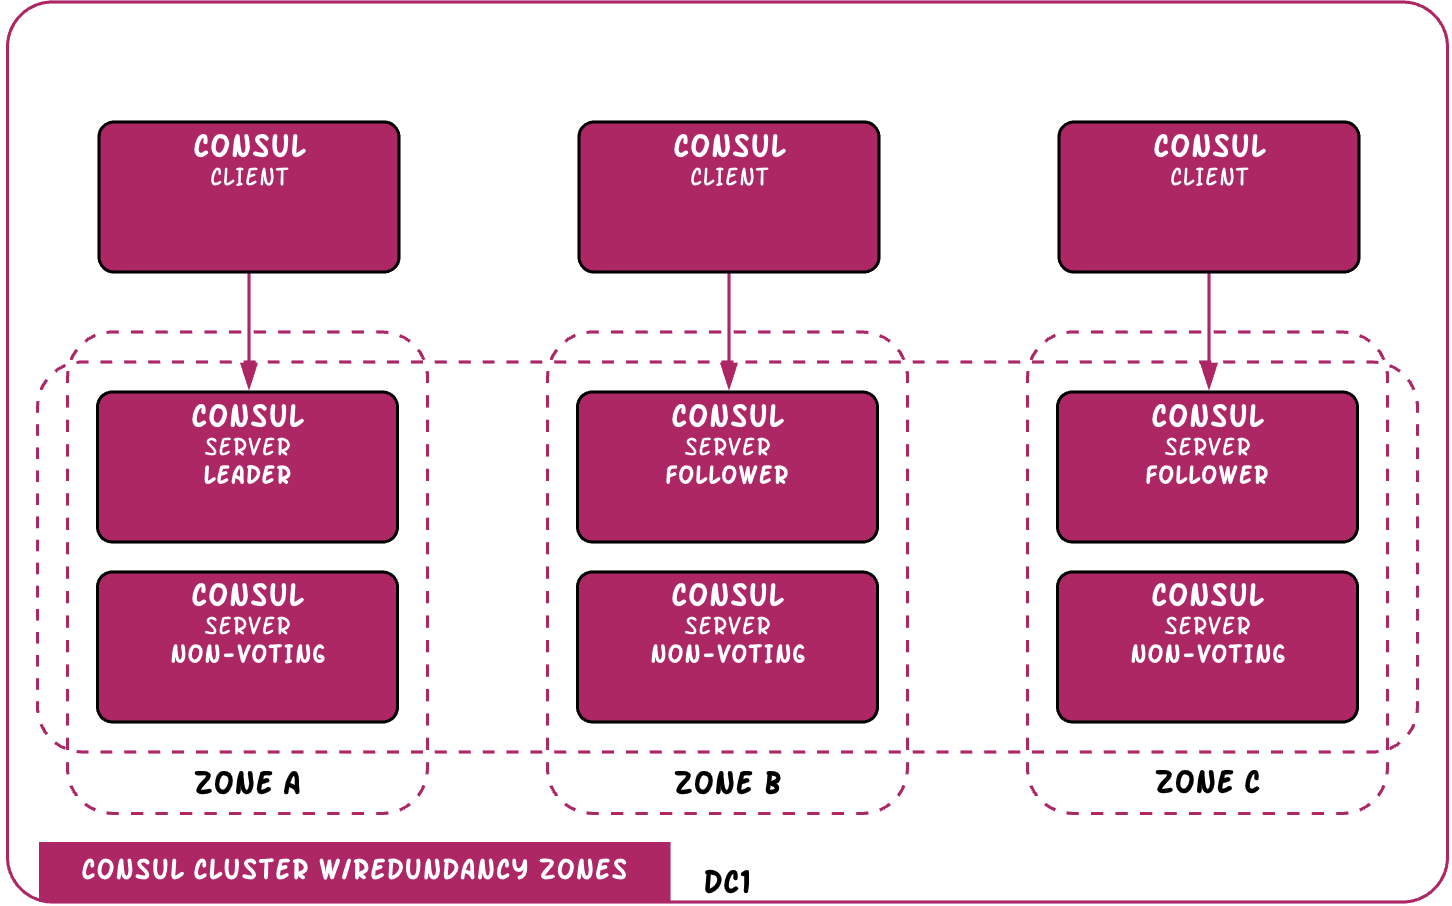

> **NOTE**: This is an Enterprise only feature.

You will configure fault resiliency for Consul using redundancy zones.

Redunancy zones is a Consul autopilot feature that makes it possible to run:
* **one voter** and any number of non-voters in each defined zone.

You will set up one voter and one non-voter in three regions.
* If one zone is completely lost, both the the voter and non-voters will be lost.
  * However, the the cluster will remain available.
* If only the voter is lost in a zone, autopilot will promote the non-voter to voter automatically.
  * Puts the hot standby server into service quickly.

You will implement isolated failure domains such as AWS Availability Zones to obtain redundancy within an AZ with less overhead sustained by a larger quorum.

### Prerequisites

You will need:
* A Consul Enterprise cluster with three servers. See `Consul Setup`.
* Three extre nodes to be used as non-voters.

### Create Consul config for Redundancy Zone.

This is for the three servers currently running. 

In [ ]:
for i in {0..2}; do
docker exec -i consul-server-${i} sh <<EOM
cat > /consul/config/rz.hcl <<EOF
node_meta {
  zone = "zone${i}"
}
EOF
cat /consul/config/rz.hcl
consul reload
EOM
done

* `node_meta` allows us to add a tag `zone` to a server
* `consul reload` triggers a reload of the configuration files. 

Verify the configuration is in place using the `/agent/self` API endpoint.

In [ ]:
for i in {0..2}; do
docker exec consul-server-${i} \
curl -s localhost:8500/v1/agent/self | jq ". | .Config, .Meta"
done

We check all three servers. We use `docker exec` since only one server container is exposing ports.

Expected Output
```json
...
{
  "consul-network-segment": "",
  "zone": "zone0"
}
...
```

### Update Consul autopilot configuration

Update Consul autopilot configuration so it knows which `node_meta` tag is used for `-redundancy-zone-tag`.

In [ ]:
#// Confirm nothing is currently set.
consul operator autopilot get-config | grep Redundancy

```
RedundancyZoneTag = ""
```

In [ ]:
consul operator autopilot set-config -redundancy-zone-tag=zone

### Verify autopilot updates

In [ ]:
consul operator autopilot get-config

Sample Output
```shell
CleanupDeadServers = true
LastContactThreshold = 200ms
MaxTrailingLogs = 250
MinQuorum = 0
ServerStabilizationTime = 10s
RedundancyZoneTag = "zone"   <==---
DisableUpgradeMigration = false
UpgradeVersionTag = ""
```

### Create Consul config - Redundancy Zone for new nodes

In [ ]:
for i in {0..2}; do
cat > consul/config/rz-${i}.hcl <<-EOF
node_meta {
  zone = "zone${i}"
}
autopilot {
  redundancy_zone_tag = "zone"
}
EOF
done

Server 3, 4, and 5 are used for various scenarios. In this scenario, we can reuse the configs from the first cluster.

In [ ]:
cp consul/config/server.hcl consul/config/server_dc2.hcl
cp consul/config/server.hcl consul/config/server_dc3.hcl
cp consul/config/server.hcl consul/config/server_dc4.hcl

Click here if you want to view the config files.
* [server.hcl](./consul/config/server.hcl)
* [server_dc2.hcl](./consul/config/server_dc2.hcl)

Modify [docker-compose-hashi.yml](docker-compose-hashi.yml). For `consul-server-3`, uncomment the image parameter for `1.9` and comment the one for `latest`. Servers 4 and 5 will inherit the settings.

```yaml
    image: hashicorp/consul-enterprise:1.9-ent
    # image: hashicorp/consul-enterprise:latest
```

### Bring up new Consul nodes

Start `consul-server-3` `consul-server-4` `consul-server-5`. Make `CONSUL_DC` `CONSUL_DC_2` and `CONSUL_DC_3` is set.

In [ ]:
docker-compose up --force-recreate -d \
  consul-server-3 consul-server-4 consul-server-5

Verify Consul with `operator` subcommand.

In [ ]:
printf "#==> List Members\n"
consul members
# curl http://127.0.0.1:8500/v1/agent/members | jq -c .[]
printf "\n#==> List Raft Peers\n"
consul operator raft list-peers

Sample Output
```
#==> List Members
Node             Address         Status  Type    Build       Protocol  DC    Segment
consul-server-0  10.5.0.2:8301   alive   server  1.9.11+ent  2         west  <all>
consul-server-1  10.5.0.3:8301   alive   server  1.9.11+ent  2         west  <all>
consul-server-2  10.5.0.4:8301   alive   server  1.9.11+ent  2         west  <all>
consul-server-3  10.5.0.7:8301   alive   server  1.9.11+ent  2         west  <all>
consul-server-4  10.5.0.6:8301   alive   server  1.9.11+ent  2         west  <all>
consul-server-5  10.5.0.5:8301   alive   server  1.9.11+ent  2         west  <all>
App1             10.5.0.12:8301  alive   client  1.9.11+ent  2         west  <default>

#==> List Raft Peers
Node             ID                                    Address        State     Voter  RaftProtocol
consul-server-0  bf8054d2-57da-128c-1a0e-b81ab694105d  10.5.0.2:8300  follower  true   3
consul-server-1  d7e82aa0-2fa0-9308-5970-44e839786d2b  10.5.0.3:8300  leader    true   3
consul-server-2  3c60ff6c-3836-9f3a-627c-80370f71b172  10.5.0.4:8300  follower  true   3
consul-server-5  b9c2c042-b161-3085-f417-d5739e6cbb50  10.5.0.5:8300  follower  false  3
consul-server-4  21c6c18d-b89d-edca-4f8e-011cbb244036  10.5.0.6:8300  follower  false  3
consul-server-3  524afd65-feea-79f2-1431-09b6dbbb8c05  10.5.0.7:8300  follower  false  3
```

* **NOTE:** All the new servers, once started, are added to the datacenter as non-voters (`Voter` = `false`). You can reference the Voter column in the output to verify it.

### Test fault tolerance

Stop one of the voters. We use `consul-server-1` from `zone1`.

In [ ]:
docker stop consul-server-1

Verify that the correspondent non-voter in its redundancy zone (`consul-server-4`) gets promoted as a voter as soon as the stopped server (`consul-server-1`) gets declared unhealthy.

In [ ]:
consul operator raft list-peers

```shell
Node             ID                                    Address        State     Voter  RaftProtocol
consul-server-0  bf8054d2-57da-128c-1a0e-b81ab694105d  10.5.0.2:8300  leader    true   3
consul-server-2  3c60ff6c-3836-9f3a-627c-80370f71b172  10.5.0.4:8300  follower  true   3
consul-server-5  b9c2c042-b161-3085-f417-d5739e6cbb50  10.5.0.5:8300  follower  false  3
consul-server-4  21c6c18d-b89d-edca-4f8e-011cbb244036  10.5.0.6:8300  follower  true   3   <==---
consul-server-3  524afd65-feea-79f2-1431-09b6dbbb8c05  10.5.0.7:8300  follower  false  3
```

* `consul-server-4` from `zone1` is now a voter

<br>Once `server-server-4` gets promoted as a voter you can start Consul on `consul-server-1` again and verify the one voter per redundancy zone rule is still respected.

In [ ]:
docker start consul-server-1

In [ ]:
consul operator raft list-peers

```shell
Node             ID                                    Address        State     Voter  RaftProtocol
consul-server-0  bf8054d2-57da-128c-1a0e-b81ab694105d  10.5.0.2:8300  leader    true   3
consul-server-2  3c60ff6c-3836-9f3a-627c-80370f71b172  10.5.0.4:8300  follower  true   3
consul-server-5  b9c2c042-b161-3085-f417-d5739e6cbb50  10.5.0.5:8300  follower  false  3
consul-server-4  21c6c18d-b89d-edca-4f8e-011cbb244036  10.5.0.6:8300  follower  true   3
consul-server-3  524afd65-feea-79f2-1431-09b6dbbb8c05  10.5.0.7:8300  follower  false  3
consul-server-1  d7e82aa0-2fa0-9308-5970-44e839786d2b  10.5.0.3:8300  follower  false  3   <==---
```

**NOTE:** `consul-server-1` is up as a `follower`, but is no longer a `voter`.

If you no longer need these nodes you can stop them.

Stop `consul-server-3` `consul-server-4` `consul-server-5`.

In [ ]:
for i in {3..5}; do
echo "#==> Stopping consul-server-${i}"
docker-compose stop consul-server-${i}
sleep 2
done

In [ ]:
consul operator raft list-peers

### Troubleshooting

```
Failed to join 10.5.0.2: No installed keys could decrypt the message
```

* https://learn.hashicorp.com/tutorials/consul/gossip-encryption-rotate

List current keys

Create new keys

In [ ]:
export CONSUL_HTTP_ADDR="http://localhost:8500"
export NEW_KEY=`consul keygen`
echo $NEW_KEY

for i in {0..5}; do
docker exec -i consul-server-${i} sh <<EOM
# Install the key
consul keyring -install ${NEW_KEY}

# Set as primary
consul keyring -use ${NEW_KEY}
EOM
done

Delete old keys

In [ ]:
for i in {0..5}; do
docker exec -i \
  -e CONSUL_HTTP_ADDR=$CONSUL_HTTP_ADDR \
  -e NEW_KEY=$NEW_KEY \
  consul-server-${i} \
  sh -s <<"EOM"
echo "#==> Retrieve all keys used by Consul"
echo "Host: $(hostname)"
KEYS=$(curl -s http://localhost:8500/v1/operator/keyring)
#echo Keys: $KEYS #DEBUGGING 
ALL_KEYS=$(echo ${KEYS} | jq -r '.[].Keys| to_entries[].key' | sort | uniq)

echo "#==> Delete all older keys used by Consul"
for i in `echo ${ALL_KEYS}`; do
  # echo $i #DEBUGGING
  if [ $i != ${NEW_KEY} ] ; then
    echo consul keyring -remove $i
    consul keyring -remove $i
  fi
done
EOM
done

`last_log_index` and `commit_index`


## Consul Federation Using WAN Gossip

* We configure two new clusters: `dc2` and `dc3` unless you renamed them in the prerequisites.
* We will use containers `consul-server-3` and `consul-server-4`for this.


### Create Server Configuration - DC2 and DC3

<img alt="consul_wan_fed_diagram" src=attachment:165e3aff-75e0-484e-80bc-0e7e4e686fd5.png width=640>
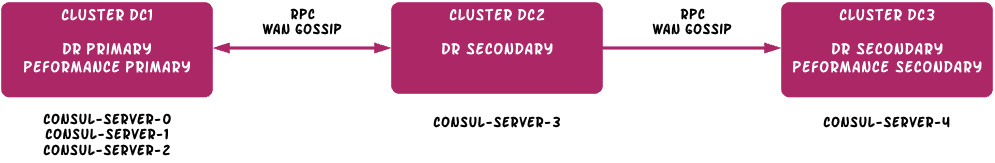

Create Core Consul config - Server

In [ ]:
#// debugging - in case variable from earlier was lost
# export CONSUL_KEY="Y+rrmAn0c9R7MLIf/eRNOjvglJA+z9dY/uqyqitaB0E="

In [ ]:
tee /tmp/consul_server.hcl.j2 <<-EOF
#// Consul Config created by automation
datacenter  = "{{cluster_name}}" # in CLI
# node_name   = "ConsulServer{{node_number}}" # in CLI
bind_addr   = "0.0.0.0" #default
client_addr = "0.0.0.0" #default 127.0.0.1
data_dir    = "/consul/data"
log_level   = "DEBUG"

encrypt     = "${CONSUL_KEY}"
ca_file     = "/consul/cert/consul-agent-ca.pem"
cert_file   = "/consul/cert/{{cluster_name}}-server-consul-0.pem"
key_file    = "/consul/cert/{{cluster_name}}-server-consul-0-key.pem"
verify_incoming = true
verify_outgoing = true
verify_server_hostname = true

# server           =  true # in CLI
bootstrap_expect = 1
#retry_join  = [ "consul-server-3", "consul-server-4", "consul-server-5" ]
ui_config { enabled = true } 

#// 5 is default multiplier
performance {
  raft_multiplier = 2 #// fast but not too fast
}

discovery_max_stale = "5s"

telemetry {
    prometheus_retention_time = "8h",
    disable_hostname = true
}

connect {
    enabled = true
}

enable_local_script_checks = true
EOF

In [ ]:
ansible localhost -m template -a "src=/tmp/consul_server.hcl.j2 dest=consul/config/server_dc2.hcl" \
    --extra-vars "node_number=3 cluster_name=${CONSUL_DC_2}"
ansible localhost -m template -a "src=/tmp/consul_server.hcl.j2 dest=consul/config/server_dc3.hcl" \
    --extra-vars "node_number=4 cluster_name=${CONSUL_DC_3}"
printf "\n#==> Verify Configs\n"
cat consul/config/server_dc2.hcl
printf "\n#==> Verify Configs\n"
cat consul/config/server_dc3.hcl

```shell
    #//
    #- NO LONGER IN USE - HERE ONLY FOR COMPARISON
    #//

    tee consul/config/server_dc2.hcl <<-EOF
    datacenter  = "${CONSUL_DC_2}" # in CLI
    # node_name   = "ConsulServer${i}" # in CLI
    bind_addr   = "0.0.0.0" #default
    client_addr = "0.0.0.0" #default 127.0.0.1
    data_dir    = "/consul/data"
    log_level   = "DEBUG"

    encrypt     = "${CONSUL_KEY}"
    ca_file     = "/consul/cert/consul-agent-ca.pem"
    cert_file   = "/consul/cert/${CONSUL_DC_2}-server-consul-0.pem"
    key_file    = "/consul/cert/${CONSUL_DC_2}-server-consul-0-key.pem"
    verify_incoming = true
    verify_outgoing = true
    verify_server_hostname = true

    # server           =  true # in CLI
    bootstrap_expect = 1
    retry_join  = [ "consul-server-3", "consul-server-4", "consul-server-5" ]
    ui_config { enabled = true } 

    #// 5 is default multiplier
    performance {
      raft_multiplier = 2 #// fast but not too fast
    }

    discovery_max_stale = "5s"

    telemetry {
        prometheus_retention_time = "8h",
        disable_hostname = true
    }

    connect {
        enabled = true
    }

    enable_local_script_checks = true
    EOF
```

### Consul docker-compose up

We will now bring up the three Consul servers in a second Consul Cluster. You can use `--force-recreate` to have Docker recreate the containers.

In [ ]:
echo $CONSUL_DC $CONSUL_DC_2 $CONSUL_DC_3
docker-compose \
  up --force-recreate -d \
  consul-server-3 consul-server-4 #consul-server-5

### Verify Consul

Quick check to make sure your Consul environment is running correctly.

#### Verify dc2

We use `docker exec` to run these commands from the containers.

In [ ]:
docker exec -i consul-server-3 sh <<EOM
echo export CONSUL_HTTP_TOKEN=$CONSUL_HTTP_TOKEN
printf "\n #==> List Members\n"
consul members
# curl http://127.0.0.1:8500/v1/agent/members | jq -c .[]
printf "\n#==> List Raft Peers\n"
consul operator raft list-peers
printf "\n#==> List services from Consul catalog\n"
consul catalog services
EOM

Confirm that the DC is your `DC2` and not your DC1.

#### Verify dc3

In [ ]:
docker exec -i consul-server-4 sh <<EOM
echo export CONSUL_HTTP_TOKEN=$CONSUL_HTTP_TOKEN
printf "#==> List Members\n"
consul members
# curl http://127.0.0.1:8500/v1/agent/members | jq -c .[]
printf "\n#==> List Raft Peers\n"
consul operator raft list-peers
printf "\n#==> List services from Consul catalog\n"
consul catalog services
EOM

Confirm that the DC is your `DC3` and not your DC1.

You should see something like the following
* There should be one server.
```
Node             Address        Status  Type    Build       Protocol  DC     Segment
consul-server-4  10.5.1.3:8301  alive   server  1.9.11+ent  2         zone3  <all>
```

* There should be only a `leader` and no `follower`'s.

```
#==> List Raft Peers
Node             ID                                    Address        State   Voter  RaftProtocol
consul-server-4  485a3739-c4fa-8265-8441-751e9f00d4dd  10.5.1.3:8300  leader  true   3
```

```
#==> List services from Consul catalog
consul
```

Look for any strangeness in the logs.

In [ ]:
for i in {3..4}; do
docker logs consul-server-${i} | (head; tail -n 5)
done

### Confirm the Datacenters are Joined and Replicating Tokens

NOTE: If ACL Tokens have not been enabled, then there will be no tokens to replicate:

First, confirm that the clusters are not aware of each other.

In [ ]:
for i in 0 3 4; do
printf "\n#==> List Consul Members\n"
docker exec consul-server-${i} consul members -wan
done

<br>Sample Output

```shell
#==> List Consul Members
Node                   Address        Status  Type    Build       Protocol  DC     Segment
consul-server-0.zone1  10.5.0.2:8302  alive   server  1.9.11+ent  2         zone1  <all>
consul-server-1.zone1  10.5.0.3:8302  alive   server  1.9.11+ent  2         zone1  <all>
consul-server-2.zone1  10.5.0.4:8302  alive   server  1.9.11+ent  2         zone1  <all>
consul-server-3.zone2  10.5.1.2:8302  failed  server  1.9.11+ent  2         zone2  <all>
consul-server-4.zone3  10.5.1.3:8302  failed  server  1.9.11+ent  2         zone3  <all>

#==> List Consul Members
Node                   Address        Status  Type    Build       Protocol  DC     Segment
consul-server-3.zone2  10.5.1.2:8302  alive   server  1.9.11+ent  2         zone2  <all>

#==> List Consul Members
Node                   Address        Status  Type    Build       Protocol  DC     Segment
consul-server-4.zone3  10.5.1.3:8302  alive   server  1.9.11+ent  2         zone3  <all>
```

Join the Datacenters - consul-server-0 will reach out to consul-server-3 and consul-server-4.

In [ ]:
consul join -wan consul-server-3 consul-server-4

#### Verify Consul Federation

Once the join is complete, the `members` command can be used to verify that all server nodes gossiping over WAN.

In [ ]:
for i in 0 3 4; do
printf "\n#==> List Consul Members\n"
docker exec consul-server-${i} consul members -wan
done

**NOTE**: Each cluster show now see members of the other clusters.

Sample Output
```shell
#==> List Consul Members
Node                   Address        Status  Type    Build       Protocol  DC     Segment
consul-server-0.zone1  10.5.0.2:8302  alive   server  1.9.11+ent  2         zone1  <all>
consul-server-1.zone1  10.5.0.3:8302  alive   server  1.9.11+ent  2         zone1  <all>
consul-server-2.zone1  10.5.0.4:8302  alive   server  1.9.11+ent  2         zone1  <all>
consul-server-3.zone2  10.5.1.2:8302  alive   server  1.9.11+ent  2         zone2  <all>
consul-server-4.zone3  10.5.1.3:8302  alive   server  1.9.11+ent  2         zone3  <all>
```

Find out which Datacenters Consul is aware of.

In [ ]:
curl http://localhost:8500/v1/catalog/datacenters

Check that ACL replication is configured properly in the secondary datacenter. **NOTE**: This should not work, yet, if you have not enabled ACL's.

In [ ]:
docker exec -i consul-server-0 sh <<EOF
echo "#==> From dc1"
apk add curl
curl -s http://localhost:8500/v1/acl/replication?pretty
printf "\n\n"; echo "#==> From dc2"
curl -s http://consul-server-3:8500/v1/acl/replication?pretty
printf "\n\n"; echo "#==> From dc3"
curl -s http://consul-server-4:8500/v1/acl/replication?pretty
EOF

Query the nodes in each datacenter

In [ ]:
for cluster in ${CONSUL_DC} ${CONSUL_DC_2} ${CONSUL_DC_3}; do
printf "\n#==> Show nodes in ${cluster}\n"
docker exec consul-server-0 \
  curl -s http://localhost:8500/v1/catalog/nodes?dc=${cluster} | jq -c .[]
done

Query for service in both datacenters - `consul.service.west.consul` and `consul.service.east.consul` 

In [ ]:
for cluster in ${CONSUL_DC} ${CONSUL_DC_2} ${CONSUL_DC_3}; do
printf "\n#==> DNS query for consul in ${cluster}\n"
dig @127.0.0.1 -p 8600 consul.service.${cluster}.consul | grep -C3 "ANSWER SECTION"
done

<br>**NOTES:**

* All server nodes must be able to talk to each other; Else gossip and RPC forwarding will not work
* Data is not replicated between Consul Clusters
  * Request made for resource in another datacenter is forwarded to remote Consul Servers
  

### Next Steps for Consul Federation

* [Prepared Queries](../Consul/consul_automate_geo_failover.ipynb)

## Consul Auto Upgrade

Modify `docker-compose-hashi.yml`. For consul-server-3, 4, and 5, comment the image parameter for `1.9` and uncomment the one for `latest`.

```yaml
    # image: hashicorp/consul-enterprise:1.9-ent
    image: hashicorp/consul-enterprise:latest
```

Start consul-server-3 consul-server-4 consul-server-5

In [ ]:
docker-compose -f docker-compose-hashi.yml up --force-recreate -d \
  consul-server-3 consul-server-4 consul-server-5

Verify Consul

In [ ]:
printf "#==> List Members\n"
consul members
# curl http://127.0.0.1:8500/v1/agent/members | jq -c .[]
printf "\n#==> List Raft Peers\n"
consul operator raft list-peers

## Consul ACL Configuration

Create Consul config for misc features eg `acl`, `performance multiplier`, etc

In [ ]:
cat > consul/config/acl.hcl << EOF
# acl = {
#   enabled = true
#   default_policy = "deny"
#   down_policy    = "extend-cache"
#   enable_token_persistence = true
#   # tokens = {
#   #   master = "49792521-8362-f878-5a32-7405f1783838"
#   # }
# }
EOF

In [ ]:
for i in {0..2}; do
docker-compose restart consul-server-${i}
sleep 3
done

In [ ]:
consul members
consul operator raft list-peers

If ACLs are enabled correctly, the leader's logs will contain the following warning and info messages.

In [ ]:
docker-compose logs --tail=100 | grep -i acl | grep INFO

### Create the bootstrap token

In [ ]:
consul acl bootstrap

**VERIFY** - The logs should contain the following log message.

In [ ]:
docker-compose logs --tail=100 | grep "ACL bootstrap"
docker-compose logs --tail=100 | grep "/v1/acl/bootstrap"

In [ ]:
echo "#==> Without Token - will see no output"
consul members
echo "#==> With Token"
CONSUL_HTTP_TOKEN=1eb8a07d-3b5a-9069-2673-e031a48851a7 consul members

### Configure Environment Variables

In [ ]:
export CONSUL_HTTP_TOKEN=1eb8a07d-3b5a-9069-2673-e031a48851a7
# export CONSUL_CACERT=/etc/training/consul/consul-agent-ca.pem
# export CONSUL_CLIENT_CERT=/etc/training/consul/<dc-name>-<server/client>-consul-<cert-number>.pem
# export CONSUL_CLIENT_KEY=/etc/training/consul/<dc-name>-<server/client>-consul-<cert-number>-key.pem

### Apply the Bootstrap Token to the Agents

In [ ]:
for i in {0..2}; do
docker exec -i consul-server-${i} sh <<EOF
hostname
consul acl set-agent-token agent $CONSUL_HTTP_TOKEN
EOF
done

ACL token "agent" set successfully

### Validate Consul Configuration

In [ ]:
consul validate consul/config/ || true

If you see this: `Config validation failed: 'bootstrap_expect > 0' requires 'server = true'`, you can ignore. We specify this from the command line.

In [ ]:
consul members
consul operator raft list-peers

Check on the UI

1. Go to http://192.168.17.101:8500
1. Then go to ACL and enter the token.
1. Go to `Nodes` tab and verify you can see the nodes.


## Vault DR and PR

# Grafana Dashboards Vault

Install Grafana Piechart plugin

In [ ]:
docker exec grafana grafana-cli plugins install grafana-piechart-panel
docker restart grafana

https://docs.datadoghq.com/integrations/vault/?tab=host


GC pause time (ns)
```
{
"viz": "timeseries",
"query": "avg:service.vault_runtime_gc_pause_ns.quantile{$vault_cluster,quantile:0.9} by {host}",
"data_source": "metrics",
"type": "line",
            "style": {
                "palette": "dog_classic",
                "type": "solid",
                "width": "normal"
            }
        }
    ],
    "yaxis": {
        "include_zero": true,
        "max": "auto",
        "scale": "linear",
        "min": "auto",
        "label": ""
    },
    "markers": []
}
```

In [ ]:
cat > scripts/generate_traffic_vault.sh <<"EOF"
#!/bin/bash
echo $VAULT_TOKEN
vault secrets list
vault secrets enable kv || true
vault secrets enable -path=kv-peter kv || true
for i in {1..10}; do
vault secrets enable -path=kv-app-${i} kv > /dev/null || true
done

printf "\n#==> write and read secrets\n"
for i in {1..10}; do
vault kv put kv/game/account-${i} username=foo-${i} password=bar
vault kv get kv/game/account-${i} > /dev/null
vault kv put kv-peter/data/game/account-${i} username=foo-${i} password=bar
vault kv get kv-peter/data/game/account-${i} > /dev/null
done

for x in {1..10}; do
  for i in {1..10}; do
    vault kv get kv/game/account-${i} > /dev/null
    vault kv get kv-peter/data/game/account-${i} > /dev/null
  done
done

printf "\n#==> write and read secrets\n"
for i in {1..10}; do
vault kv put kv-app-${i}/game/account-${i} username=foo-${i} password=bar
vault kv get kv-app-${i}/game/account-${i} > /dev/null
done

printf "\n#==> create tokens\n"
for i in {1..10}; do
vault token create \
  -field=token \
  -policy prometheus-metrics \
  -ttl=1h
done

printf "\n#==> Enable userpass\n"
vault auth enable userpass || true
vault write auth/userpass/users/mitchellh password=foo policies=admin
for i in {1..10}; do
printf "\n#==> create userpass user\n"
vault write auth/userpass/users/user-${i} password=foo policies=operators \
    token_ttl=3h policies=operators
printf "\n#==> login with userpass user\n"
vault login -method=userpass username=user-${i} password=foo
done

printf "\n#==> Enable AppRoles\n"
vault auth enable approle || true

printf "\n#==> Create AppRoles and login\n"
for i in {10..19}; do
    vault write -f auth/approle/role/app${i} \
        token_ttl=2h \
        token_max_ttl=3h \
        token_bound_cidrs="0.0.0.0/0","127.0.0.1/32" \
        token_num_uses=10
    vault write auth/approle/login \
        role_id=$(vault read -field=role_id auth/approle/role/app${i}/role-id) \
        secret_id=$(vault write -force -field=secret_id auth/approle/role/app${i}/secret-id)
done

EOF

chmod +x scripts/generate_traffic_vault.sh

Run script and display for debugging.

In [ ]:
# make generate_vault
# scripts/generate_traffic_vault.sh

Run script in background.

In [ ]:
for i in {1..3}; do
scripts/generate_traffic_vault.sh > /tmp/generate_traffic_vault.out 2>&1 &
done

In [ ]:
tail /tmp/generate_traffic_vault.out

In [ ]:
# for i in {1..10}; do
# vault write auth/userpass/users/user-${i} password=foo policies=admins
# done

for i in {1..10}; do
# vault kv list kv-app-${i}/game > /dev/null
vault login -method=userpass username=user-${i} password=foo 2>&1 > /dev/null
done

# Nomad

Create needed directories.

In [ ]:
echo "--> Writing configuration"
# sudo mkdir -p /mnt/nomad
# sudo mkdir -p /etc/nomad.d
mkdir -p nomad/config
mkdir -p nomad/cert/{server,client}

echo "--> clean up any default config."
# sudo rm  /etc/nomad.d/*

### Create Nomad Configs

In [ ]:
# sudo tee /etc/nomad.d/nomad.hcl > /dev/null <<EOF
sudo tee nomad/config/nomad.hcl > /dev/null <<EOF

name         = "${node_name}"
data_dir     = "/mnt/nomad"
enable_debug = true
bind_addr = "0.0.0.0"
datacenter = "$AWS_AZ"
region = "$AWS_REGION"
advertise {
  http = "$(public_ip):4646"
  rpc  = "$(public_ip):4647"
  serf = "$(public_ip):4648"
}
server {
  enabled          = true
  bootstrap_expect = ${nomad_servers}
  encrypt          = "${nomad_gossip_key}"
}
client {
  enabled = true
   options {
    "driver.raw_exec.enable" = "1"
     "docker.privileged.enabled" = "true"
  }
  meta {
    "type" = "server",
    "name" = "${node_name}"
  }
}
tls {
  rpc  = true
  http = true
  ca_file   = "/usr/local/share/ca-certificates/01-me.crt"
  cert_file = "/etc/ssl/certs/me.crt"
  key_file  = "/etc/ssl/certs/me.key"
  verify_server_hostname = false
}
consul {
    address = "localhost:8500"
    server_service_name = "nomad-server"
    client_service_name = "nomad-client"
    auto_advertise = true
    server_auto_join = true
    client_auto_join = true
}
vault {
  enabled          = true
  address          = "https://active.vault.service.consul:8200"
  ca_file          = "/usr/local/share/ca-certificates/01-me.crt"
  cert_file        = "/etc/ssl/certs/me.crt"
  key_file         = "/etc/ssl/certs/me.key"
  create_from_role = "nomad-cluster"
}
autopilot {
    cleanup_dead_servers = true
    last_contact_threshold = "200ms"
    max_trailing_logs = 250
    server_stabilization_time = "10s"
    enable_redundancy_zones = false
    disable_upgrade_migration = false
    enable_custom_upgrades = false
}
telemetry {
  publish_allocation_metrics = true
  publish_node_metrics = true
  prometheus_metrics = true
}
EOF

### Nomad - Shell customizations

In [ ]:
echo "--> Writing profile"
sudo tee /etc/profile.d/nomad.sh > /dev/null <<"EOF"
alias noamd="nomad"
alias nomas="nomad"
alias nomda="nomad"
# export NOMAD_ADDR="https://${node_name}.node.consul:4646"
# export NOMAD_CACERT="/usr/local/share/ca-certificates/01-me.crt"
# export NOMAD_CLIENT_CERT="/etc/ssl/certs/me.crt"
# export NOMAD_CLIENT_KEY="/etc/ssl/certs/me.key"
EOF
source /etc/profile.d/nomad.sh

### Nomad - systemd configuration

optional step

```shell
echo "--> Generating systemd configuration"
sudo tee /etc/systemd/system/nomad.service > /dev/null <<EOF
[Unit]
Description=Nomad
Documentation=https://www.nomadproject.io/docs/
Requires=network-online.target
After=network-online.target
[Service]
Environment=VAULT_TOKEN=$NOMAD_VAULT_TOKEN
ExecStart=/usr/bin/nomad agent -config="/etc/nomad.d"
ExecReload=/bin/kill -HUP $MAINPID
KillSignal=SIGINT
Restart=on-failure
LimitNOFILE=65536
#Enterprise License
Environment=NOMAD_LICENSE=${nomadlicense}
[Install]
WantedBy=multi-user.target
EOF

sudo systemctl enable nomad
sudo systemctl start nomad
sleep 5
```

### Start Nomad

Run Nomad as dev server with default configs.

In [ ]:
nomad agent -dev -bind 0.0.0.0 -log-level INFO \
    -consul-address=127.0.0.1:8500 > /tmp/nomad.log 2>&1 &

In [ ]:
tail /tmp/nomad.log

In [ ]:
printf "#==> List registered nodes in Cluster\n"
nomad node status

printf "\n#==> List members of gossip ring\n"
nomad server members

### Nomad Web UI

Access the web user interface at:
http://localhost:4646 or
http://192.168.17.101:4646 (replace with your IP)

* **Jobs** section is bare.
* **Clients** - Should see three nodes (number might be different for you)
	* Click on a node to see more info:
	* (bottom) OS, Nomad version, resource and task drivers available
* **Servers** - Should see three nodes; Same three in clients (number might be different for you)
	* Which one is leader?

For more information, take a look at the  [Web UI tutorial](https://learn.hashicorp.com/nomad/getting-started/ui) .

### Run first job

Now that Nomad is up and running, we can schedule our very first job. We will be running the `http-echo` Docker container. This is a simple application that renders an HTML page containing the arguments passed to the `http-echo` process such as "**Hello World**". The process listens on a port such as **8080** provided by another argument.

A simple job file that describes this looks like this:

```go
job "http-echo" {
  datacenters = ["dc1"]
  group "echo" {
    count = 1
    task "server" {
      driver = "docker"
      config {
        image = "hashicorp/http-echo:latest"
        args  = [
          "-listen", ":8081",
          "-text", "Hello and welcome to 127.0.0.1 running on port 8080",
        ]
      }
      resources {
        network {
          mbits = 10
          port "http" {
            static = 8081
          }
        }
      }
    }
  }
}
```

In this file, we will:
* create a job called `http-echo`
* set the driver to use `docker`
* pass the necessary `text` and `port` arguments to the container
* we need network access to the container to display the resulting webpage
    * define the `resources` section to require a network with port `8080` open from the host machine to the container.

Generate sample job

In [ ]:
nomad job init /tmp/example.nomad

**NOTE**: Create sample job without comments or unnecessary stanzas.

```shell
nomad job init -short /tmp/example.nomad
```

View sample job

In [ ]:
cat /tmp/example.nomad

Register the example job

In [ ]:
nomad job run /tmp/example.nomad > /tmp/example.nomad.out

In [ ]:
cat /tmp/example.nomad.out

Inspect the status of your job

In [ ]:
nomad job status example 

In [ ]:
nomad job status example

<br>Sample Output
```
ID            = example
Name          = example
Submit Date   = 2021-12-16T16:22:27Z
Type          = service
Priority      = 50
Datacenters   = dc1
Namespace     = default
Status        = running
Periodic      = false
Parameterized = false

Summary
Task Group  Queued  Starting  Running  Failed  Complete  Lost
cache       0       0         1        0       0         0

Latest Deployment
ID          = 9fe1f2fe
Status      = successful
Description = Deployment completed successfully

Deployed
Task Group  Desired  Placed  Healthy  Unhealthy  Progress Deadline
cache       1        1       1        0          2021-12-16T16:32:58Z

Allocations
ID        Node ID   Task Group  Version  Desired  Status   Created    Modified
3a30546f  04e9440d  cache       0        run      running  10m9s ago  9m37s ago
```

Replace the alloc with your own

In [ ]:
ALLOC_ID=3a30546f

In [ ]:
nomad alloc status ${ALLOC_ID}

Fetch job logs - replace alloc id with your own

In [ ]:
nomad alloc logs ${ALLOC_ID} redis

In [ ]:
nomad stop example

In [ ]:
pkill nomad

# Hashicups

In [ ]:
scripts/build_images.sh

In [ ]:
docker-compose up -d \
    frontend public-api product-api product-db payments

In [ ]:
docker-compose up -d \
    payments && docker logs payments

In [ ]:
docker logs payments